## Importing libraries

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import shap
import joblib
import warnings

# load JS visualization code to notebook. Without this, the SHAP plots won't be displayed
shap.initjs()

#removing the warnings display
warnings.filterwarnings('ignore')

## Loading the data

In [2]:
loan_data  = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_train.csv" )
test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_test.csv')

#data size
loan_data.shape

(491, 14)

## Exploratory Analysis

In [3]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         491 non-null    int64  
 1   Loan_ID            491 non-null    object 
 2   Gender             481 non-null    object 
 3   Married            490 non-null    object 
 4   Dependents         482 non-null    object 
 5   Education          491 non-null    object 
 6   Self_Employed      462 non-null    object 
 7   ApplicantIncome    491 non-null    int64  
 8   CoapplicantIncome  491 non-null    float64
 9   LoanAmount         475 non-null    float64
 10  Loan_Amount_Term   478 non-null    float64
 11  Credit_History     448 non-null    float64
 12  Property_Area      491 non-null    object 
 13  Loan_Status        491 non-null    int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 53.8+ KB


In [4]:
loan_data.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,LP002305,Female,No,0,Graduate,No,4547,0.0,115.0,360.0,1.0,Semiurban,1
1,1,LP001715,Male,Yes,3+,Not Graduate,Yes,5703,0.0,130.0,360.0,1.0,Rural,1
2,2,LP002086,Female,Yes,0,Graduate,No,4333,2451.0,110.0,360.0,1.0,Urban,0
3,3,LP001136,Male,Yes,0,Not Graduate,Yes,4695,0.0,96.0,NaN,1.0,Urban,1
4,4,LP002529,Male,Yes,2,Graduate,No,6700,1750.0,230.0,300.0,1.0,Semiurban,1


The index was imported as a column while loading the csv so we will drop it along with the loan_id column that has no use in the model building.


In [5]:
loan_data.drop(columns={'Unnamed: 0','Loan_ID'},inplace=True)


In [6]:
#Constructing a dataframe with the variable types and missing values per column
consistency = pd.DataFrame({'columns' : loan_data.columns,
                    'type': loan_data.dtypes,
                    'missing' : loan_data.isna().sum(),
                    'size' : loan_data.shape[0],
                    'unique': loan_data.nunique()})
consistency['percentage'] = round(consistency['missing'] / consistency['size'],2)
consistency

,columns,type,missing,size,unique,percentage
Gender,Gender,object,10,491,2,0.02
Married,Married,object,1,491,2,0.00
Dependents,Dependents,object,9,491,4,0.02
Education,Education,object,0,491,2,0.00
Self_Employed,Self_Employed,object,29,491,2,0.06
ApplicantIncome,ApplicantIncome,int64,0,491,408,0.00
CoapplicantIncome,CoapplicantIncome,float64,0,491,239,0.00
LoanAmount,LoanAmount,float64,16,491,176,0.03
Loan_Amount_Term,Loan_Amount_Term,float64,13,491,10,0.03
Credit_History,Credit_History,float64,43,491,2,0.09


We can see that there quite a few columns that have missing values, let's start by checking if the missing values have coinciding rows.
For that we will the dataframe above but while subselecting the rows with missing values per column.

In [7]:
loan_data.loc[loan_data.loc[:,'Gender'].isna()].loc[loan_data.loc[loan_data.loc[:,'Gender'].isna()].loc[:,'Gender'].isna()]

consistency = pd.DataFrame({'columns' : loan_data.loc[loan_data.loc[:,'Gender'].isna()].columns,
                    'type': loan_data.loc[loan_data.loc[:,'Gender'].isna()].dtypes,
                    'missing' : loan_data.loc[loan_data.loc[:,'Gender'].isna()].isna().sum(),
                    'size' : loan_data.loc[loan_data.loc[:,'Gender'].isna()].shape[0],
                    'unique': loan_data.loc[loan_data.loc[:,'Gender'].isna()].nunique()})
consistency['percentage'] = round(consistency['missing'] / consistency['size'],2)
consistency

,columns,type,missing,size,unique,percentage
Gender,Gender,object,10,10,0,1.0
Married,Married,object,0,10,2,0.0
Dependents,Dependents,object,0,10,4,0.0
Education,Education,object,0,10,1,0.0
Self_Employed,Self_Employed,object,0,10,2,0.0
ApplicantIncome,ApplicantIncome,int64,0,10,10,0.0
CoapplicantIncome,CoapplicantIncome,float64,0,10,6,0.0
LoanAmount,LoanAmount,float64,0,10,10,0.0
Loan_Amount_Term,Loan_Amount_Term,float64,0,10,3,0.0
Credit_History,Credit_History,float64,1,10,2,0.1


In [8]:
loan_data.loc[loan_data.loc[:,'Dependents'].isna()].loc[loan_data.loc[loan_data.loc[:,'Dependents'].isna()].loc[:,'Dependents'].isna()]

consistency = pd.DataFrame({'columns' : loan_data.loc[loan_data.loc[:,'Dependents'].isna()].columns,
                    'type': loan_data.loc[loan_data.loc[:,'Dependents'].isna()].dtypes,
                    'missing' : loan_data.loc[loan_data.loc[:,'Dependents'].isna()].isna().sum(),
                    'size' : loan_data.loc[loan_data.loc[:,'Dependents'].isna()].shape[0],
                    'unique': loan_data.loc[loan_data.loc[:,'Dependents'].isna()].nunique()})
consistency['percentage'] = round(consistency['missing'] / consistency['size'],2)
consistency

,columns,type,missing,size,unique,percentage
Gender,Gender,object,0,9,2,0.00
Married,Married,object,1,9,2,0.11
Dependents,Dependents,object,9,9,0,1.00
Education,Education,object,0,9,2,0.00
Self_Employed,Self_Employed,object,0,9,2,0.00
ApplicantIncome,ApplicantIncome,int64,0,9,9,0.00
CoapplicantIncome,CoapplicantIncome,float64,0,9,6,0.00
LoanAmount,LoanAmount,float64,0,9,9,0.00
Loan_Amount_Term,Loan_Amount_Term,float64,1,9,3,0.11
Credit_History,Credit_History,float64,0,9,2,0.00


In [9]:
loan_data.loc[loan_data.loc[:,'Credit_History'].isna()].loc[loan_data.loc[loan_data.loc[:,'Credit_History'].isna()].loc[:,'Credit_History'].isna()]

consistency = pd.DataFrame({'columns' : loan_data.loc[loan_data.loc[:,'Credit_History'].isna()].columns,
                    'type': loan_data.loc[loan_data.loc[:,'Credit_History'].isna()].dtypes,
                    'missing' : loan_data.loc[loan_data.loc[:,'Credit_History'].isna()].isna().sum(),
                    'size' : loan_data.loc[loan_data.loc[:,'Credit_History'].isna()].shape[0],
                    'unique': loan_data.loc[loan_data.loc[:,'Credit_History'].isna()].nunique()})
consistency['percentage'] = round(consistency['missing'] / consistency['size'],2)
consistency

,columns,type,missing,size,unique,percentage
Gender,Gender,object,1,43,2,0.02
Married,Married,object,0,43,2,0.00
Dependents,Dependents,object,0,43,4,0.00
Education,Education,object,0,43,2,0.00
Self_Employed,Self_Employed,object,6,43,2,0.14
ApplicantIncome,ApplicantIncome,int64,0,43,41,0.00
CoapplicantIncome,CoapplicantIncome,float64,0,43,27,0.00
LoanAmount,LoanAmount,float64,1,43,39,0.02
Loan_Amount_Term,Loan_Amount_Term,float64,0,43,7,0.00
Credit_History,Credit_History,float64,43,43,0,1.00


In [10]:
loan_data.loc[loan_data.loc[:,'Self_Employed'].isna()].loc[loan_data.loc[loan_data.loc[:,'Self_Employed'].isna()].loc[:,'Self_Employed'].isna()]

consistency = pd.DataFrame({'columns' : loan_data.loc[loan_data.loc[:,'Self_Employed'].isna()].columns,
                    'type': loan_data.loc[loan_data.loc[:,'Self_Employed'].isna()].dtypes,
                    'missing' : loan_data.loc[loan_data.loc[:,'Self_Employed'].isna()].isna().sum(),
                    'size' : loan_data.loc[loan_data.loc[:,'Self_Employed'].isna()].shape[0],
                    'unique': loan_data.loc[loan_data.loc[:,'Self_Employed'].isna()].nunique()})
consistency['percentage'] = round(consistency['missing'] / consistency['size'],2)
consistency

,columns,type,missing,size,unique,percentage
Gender,Gender,object,0,29,2,0.00
Married,Married,object,0,29,2,0.00
Dependents,Dependents,object,0,29,4,0.00
Education,Education,object,0,29,2,0.00
Self_Employed,Self_Employed,object,29,29,0,1.00
ApplicantIncome,ApplicantIncome,int64,0,29,29,0.00
CoapplicantIncome,CoapplicantIncome,float64,0,29,17,0.00
LoanAmount,LoanAmount,float64,1,29,23,0.03
Loan_Amount_Term,Loan_Amount_Term,float64,1,29,2,0.03
Credit_History,Credit_History,float64,6,29,2,0.21


We can conclude that there is no obvious overlap between the missing values.
So we'll take a column by column and in the end we'll decide what to do with them.

In [11]:
#creating list with the categorical and numerical variables respectively
categorical = ['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Property_Area']
numerical = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']

Starting with the categorical variables

## Gender

In [12]:
loan_data.Gender.value_counts(), loan_data.Gender.value_counts().sum(), loan_data.shape[0]

(Male      393
 Female     88
 Name: Gender, dtype: int64,
 481,
 491)

The majority of entries are male. we could fill the missing values with the most frequent value, however that will further increase the bias.
So the solution here, might be creating a new column with undefined gender.

## Married

In [13]:
loan_data.Married.value_counts(), loan_data.Married.value_counts().sum(), loan_data.shape[0]

(Yes    324
 No     166
 Name: Married, dtype: int64,
 490,
 491)

## Dependents

In [14]:
loan_data.Dependents.value_counts(), loan_data.Dependents.value_counts().sum(), loan_data.shape[0]

(0     276
 1      85
 2      78
 3+     43
 Name: Dependents, dtype: int64,
 482,
 491)

## Education

In [15]:
loan_data.Education.value_counts(), loan_data.Education.value_counts().sum(), loan_data.shape[0]

(Graduate        388
 Not Graduate    103
 Name: Education, dtype: int64,
 491,
 491)

## Self Employed

In [16]:
loan_data.Self_Employed.value_counts(), loan_data.Self_Employed.value_counts().sum(), loan_data.shape[0]

(No     398
 Yes     64
 Name: Self_Employed, dtype: int64,
 462,
 491)

## Credit History

In [17]:
loan_data.Credit_History.value_counts(), loan_data.Credit_History.value_counts().sum(), loan_data.shape[0]

(1.0    380
 0.0     68
 Name: Credit_History, dtype: int64,
 448,
 491)

## Property Area

In [18]:
loan_data.Property_Area.value_counts(), loan_data.Property_Area.value_counts().sum(), loan_data.shape[0]

(Semiurban    186
 Urban        155
 Rural        150
 Name: Property_Area, dtype: int64,
 491,
 491)

## Loan Status (target variable)

In [19]:
loan_data.Loan_Status.value_counts()

1    343
0    148
Name: Loan_Status, dtype: int64

In [20]:
#percentage of given loans
sum(loan_data.Loan_Status==0)/loan_data.Loan_Status.shape[0], sum(loan_data.Loan_Status==1)/loan_data.Loan_Status.shape[0]

(0.3014256619144603, 0.6985743380855397)

For the Married and Dependents columns, there is an inherit default status. That is one starts the life not married and with 0 dependents, so for the missing values in these columns we'll replace them by No and 0 respectively.

As for Gender things can be quite more complicated, if a person only had those two choices to begin with, they could simply not indentify with either, or even prefer not to answer. So we'll one hot enconde this column with the 3rd option being NA, which we'll consider to be not enough information.

We'll apply the same concept to the Credit History, as we'll consider the missing values as not having enough information as the 3rd column.

Finally the Self Employed column, we'll simply replace with the majority of the values which is no. The expected scenario is that the majority of the people isn't self employed, and unless we know before hand that the dataset represents a specific group of people or region that behaves differently there is no reason to revert this decision.

Before proceeding with the respective transformations we'll take a look at how the variables are distributed, as well as the target variable distribution within them.

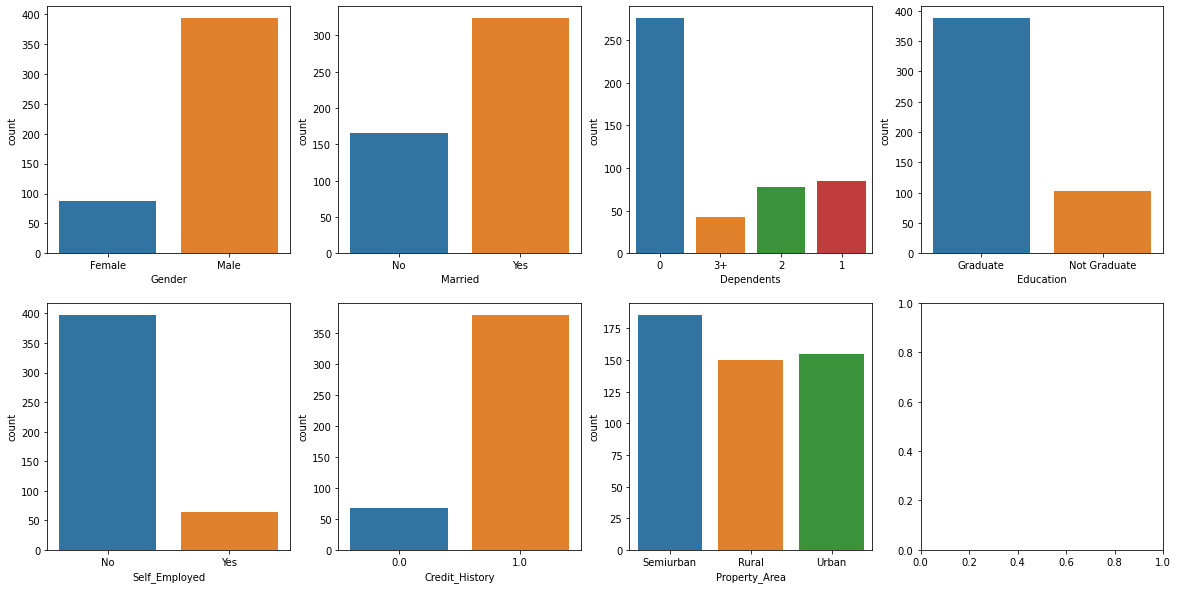

In [21]:
#bar plot of each categorical variable
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(loan_data[variable], ax=subplot)

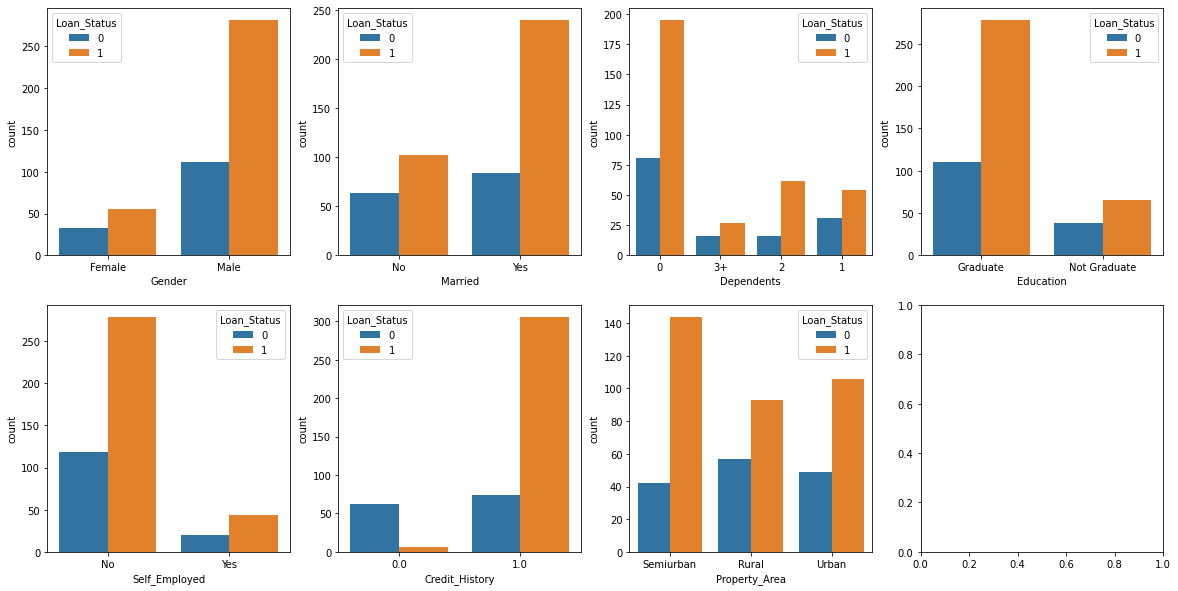

In [22]:
#again but this time with the target variable
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(loan_data[variable], ax=subplot, hue=loan_data['Loan_Status'])

In [23]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(columns=col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df;

dummy_na = True #see why above
dummy_cols =['Gender', 'Credit_History']

#dummifying the columns above
loan_data = create_dummy_df(loan_data,dummy_cols,dummy_na)

In [24]:
loan_data['Married'].fillna('No',inplace=True)
loan_data['Dependents'].fillna('0',inplace=True)#this column is string type thus the '0'
loan_data['Self_Employed'].fillna('No',inplace=True)

dummy_na = False #see why above
dummy_cols =['Married', 'Dependents','Education','Self_Employed','Property_Area']

#dummifying the columns above
loan_data = create_dummy_df(loan_data,dummy_cols,dummy_na)
loan_data

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Gender_Male,Gender_nan,Credit_History_1.0,Credit_History_nan,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,4547,0.0,115.0,360.0,1,0,0,1,0,0,0,0,0,0,0,1,0
1,5703,0.0,130.0,360.0,1,1,0,1,0,1,0,0,1,1,1,0,0
2,4333,2451.0,110.0,360.0,0,0,0,1,0,1,0,0,0,0,0,0,1
3,4695,0.0,96.0,NaN,1,1,0,1,0,1,0,0,0,1,1,0,1
4,6700,1750.0,230.0,300.0,1,1,0,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,9833,1833.0,182.0,180.0,1,0,1,1,0,1,1,0,0,0,1,0,1
487,3812,0.0,112.0,360.0,1,0,0,1,0,0,1,0,0,0,0,0,0
488,14583,0.0,185.0,180.0,1,1,0,1,0,1,1,0,0,0,0,0,0
489,1836,33837.0,90.0,360.0,0,1,0,1,0,0,0,0,0,0,0,0,1


Moving on to the numerical type variables

## Applicant Income

In [25]:
#frequency
loan_data.ApplicantIncome.value_counts()

4583     6
6000     5
4166     5
2500     5
8333     4
        ..
5821     1
2750     1
5829     1
20166    1
3598     1
Name: ApplicantIncome, Length: 408, dtype: int64

In [26]:
#minimum and maximum values
loan_data.ApplicantIncome.min(),loan_data.ApplicantIncome.max()

(150, 81000)

<AxesSubplot:ylabel='Frequency'>

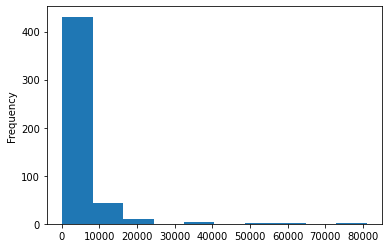

In [27]:
#distribution
loan_data['ApplicantIncome'].plot.hist(bins=10)

<AxesSubplot:ylabel='ApplicantIncome'>

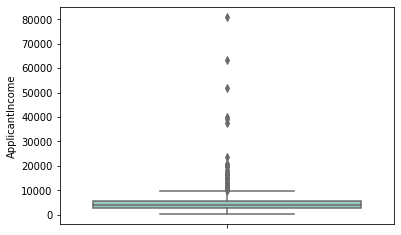

In [28]:
#looking for outliers through a boxplot
sns.boxplot(y="ApplicantIncome", hue="Loan_Status",

                 data=loan_data, palette="Set3")

In [29]:
#number of values over 30k
len(loan_data.loc[loan_data.loc[:,'ApplicantIncome']>30000])

6

<AxesSubplot:ylabel='Frequency'>

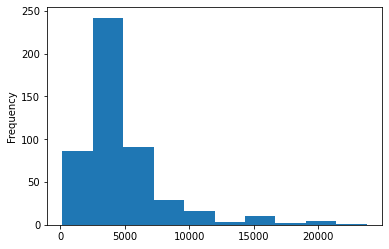

In [30]:
#distribution under 30k
loan_data.loc[loan_data.loc[:,'ApplicantIncome']<30000,'ApplicantIncome'].plot.hist(bins=10)

In [31]:
#number of values over 10k and 20k respectively
len(loan_data.loc[loan_data.loc[:,'ApplicantIncome']>10000]),len(loan_data.loc[loan_data.loc[:,'ApplicantIncome']>20000])

(37, 11)

In [32]:
#percentage of the values over 20k and over 30k respectively
11/loan_data.shape[0], 6/loan_data.shape[0]

(0.02240325865580448, 0.012219959266802444)

<AxesSubplot:ylabel='Frequency'>

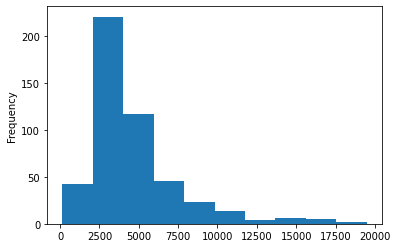

In [33]:
#distribution under 20k
loan_data.loc[loan_data.loc[:,'ApplicantIncome']<20000,'ApplicantIncome'].plot.hist(bins=10)

We are going to consider that every value above 30k is an outlier and consequently we'll remove the respective rows.

## Coapplicant Income

In [34]:
#frequency
loan_data.CoapplicantIncome.value_counts()

0.0       215
2500.0      5
2083.0      5
1666.0      3
1750.0      3
         ... 
2014.0      1
2004.0      1
2504.0      1
997.0       1
1447.0      1
Name: CoapplicantIncome, Length: 239, dtype: int64

In [35]:
#minimum and maximum values
loan_data.CoapplicantIncome.min(),loan_data.CoapplicantIncome.max()

(0.0, 41667.0)

<AxesSubplot:ylabel='Frequency'>

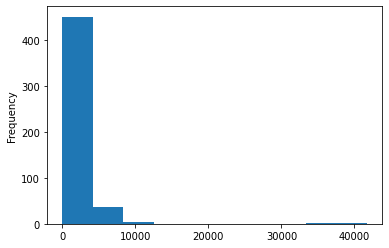

In [36]:
#distribution
loan_data['CoapplicantIncome'].plot.hist(bins=10)

<AxesSubplot:ylabel='CoapplicantIncome'>

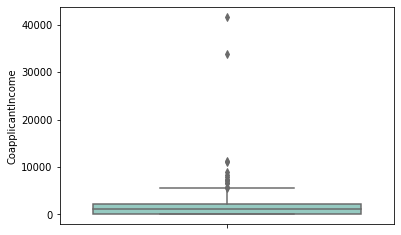

In [37]:
#looking for outliers through a boxplot
sns.boxplot(y="CoapplicantIncome", hue="Loan_Status",

                 data=loan_data, palette="Set3")

In [38]:
#number of values over 10k and 20k respectively
len(loan_data.loc[loan_data.loc[:,'CoapplicantIncome']>10000]),len(loan_data.loc[loan_data.loc[:,'CoapplicantIncome']>20000])

(4, 2)

In [39]:
#percentage of the values over 10k and over 20k respectively
4/loan_data.shape[0], 2/loan_data.shape[0]

(0.008146639511201629, 0.004073319755600814)

<AxesSubplot:ylabel='Frequency'>

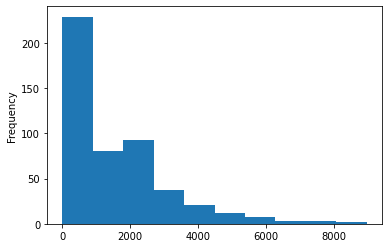

In [40]:
#distribution under 10k
loan_data.loc[loan_data.loc[:,'CoapplicantIncome']<10000,'CoapplicantIncome'].plot.hist(bins=10)

Again we are going to consider that every value above 10k is an outlier and we'll remove the respective rows.

## Loan Amount

In [41]:
#number of missing values
loan_data.LoanAmount.isna().sum()

16

In [42]:
#frequency
loan_data.LoanAmount.value_counts()

120.0    17
110.0    13
100.0    13
128.0    11
160.0    11
         ..
436.0     1
253.0     1
85.0      1
129.0     1
315.0     1
Name: LoanAmount, Length: 176, dtype: int64

In [43]:
#minimum and maximum values
loan_data.LoanAmount.min(),loan_data.LoanAmount.max()

(17.0, 700.0)

<AxesSubplot:ylabel='Frequency'>

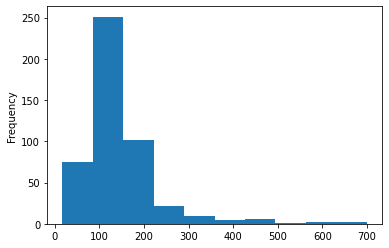

In [44]:
#distribution
loan_data.LoanAmount.plot.hist(bins=10)

<AxesSubplot:ylabel='LoanAmount'>

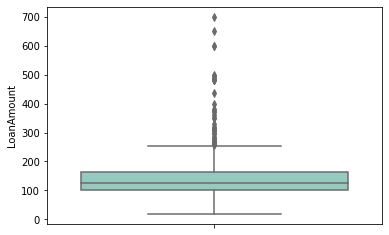

In [45]:
#looking for outliers through a boxplot
sns.boxplot(y="LoanAmount", hue="Loan_Status",

                 data=loan_data, palette="Set3")

In [46]:
#number of values over 300 and 500 respectively
len(loan_data.loc[loan_data.loc[:,'LoanAmount']>300]),len(loan_data.loc[loan_data.loc[:,'LoanAmount']>500])

(24, 4)

## Loan Amount Term

In [47]:
#number of missing values
loan_data.Loan_Amount_Term.isna().sum()

13

In [48]:
#frequency
loan_data.Loan_Amount_Term.value_counts()

360.0    404
180.0     35
480.0     13
300.0     12
84.0       4
120.0      3
240.0      3
36.0       2
60.0       1
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [49]:
#minimum and maximum values
loan_data.Loan_Amount_Term.min(), loan_data.Loan_Amount_Term.max()

(12.0, 480.0)

<AxesSubplot:ylabel='Frequency'>

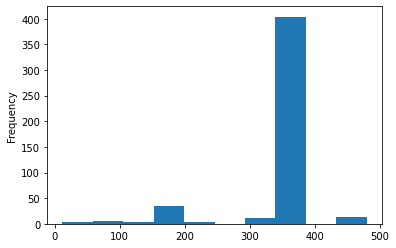

In [50]:
#distribution
loan_data.Loan_Amount_Term.plot.hist(bins=10)

<AxesSubplot:ylabel='Loan_Amount_Term'>

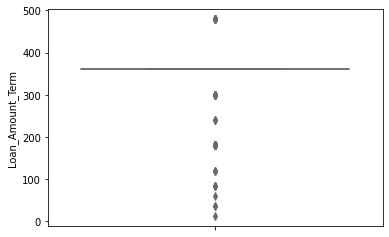

In [51]:
#looking for outliers through a boxplot
sns.boxplot(y="Loan_Amount_Term", hue="Loan_Status",

                 data=loan_data, palette="Set3")

In order to take action on both the Loan amount and loan amount term columns further information is needed, as the outliers here might be coherent.
Since these columns have missing values as well we'll first remove the outliers from the columns above and afterwards we'll fill the missing values with the median.

We'll chose the median so that possible weird values that we cannot interpret without further information don't add further noise to the data.

In [52]:
#removing the outliers
loan_data = loan_data.loc[loan_data.loc[:,'ApplicantIncome']<30000]
loan_data = loan_data.loc[loan_data.loc[:,'CoapplicantIncome']<10000]
loan_data

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Gender_Male,Gender_nan,Credit_History_1.0,Credit_History_nan,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,4547,0.0,115.0,360.0,1,0,0,1,0,0,0,0,0,0,0,1,0
1,5703,0.0,130.0,360.0,1,1,0,1,0,1,0,0,1,1,1,0,0
2,4333,2451.0,110.0,360.0,0,0,0,1,0,1,0,0,0,0,0,0,1
3,4695,0.0,96.0,NaN,1,1,0,1,0,1,0,0,0,1,1,0,1
4,6700,1750.0,230.0,300.0,1,1,0,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,3660,5064.0,187.0,360.0,1,1,0,1,0,0,0,0,0,0,0,1,0
486,9833,1833.0,182.0,180.0,1,0,1,1,0,1,1,0,0,0,1,0,1
487,3812,0.0,112.0,360.0,1,0,0,1,0,0,1,0,0,0,0,0,0
488,14583,0.0,185.0,180.0,1,1,0,1,0,1,1,0,0,0,0,0,0


Before looking filling the missing values we'll take a quick look at the distribution plots

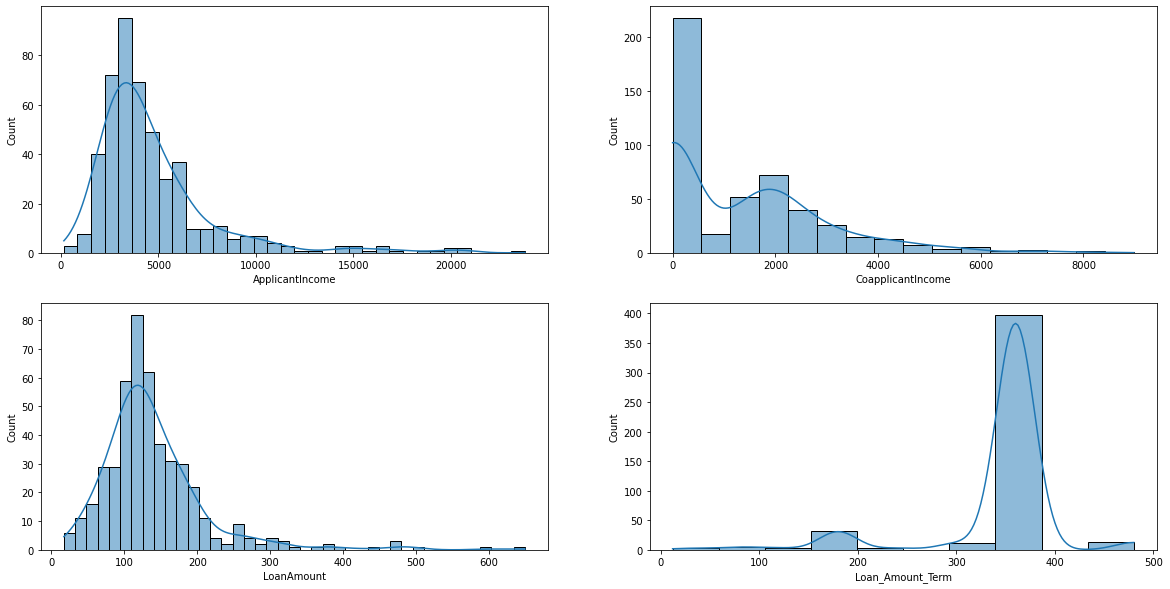

In [53]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for variable, subplot in zip(numerical, ax.flatten()):
    sns.histplot(loan_data[variable], ax=subplot,kde=True)

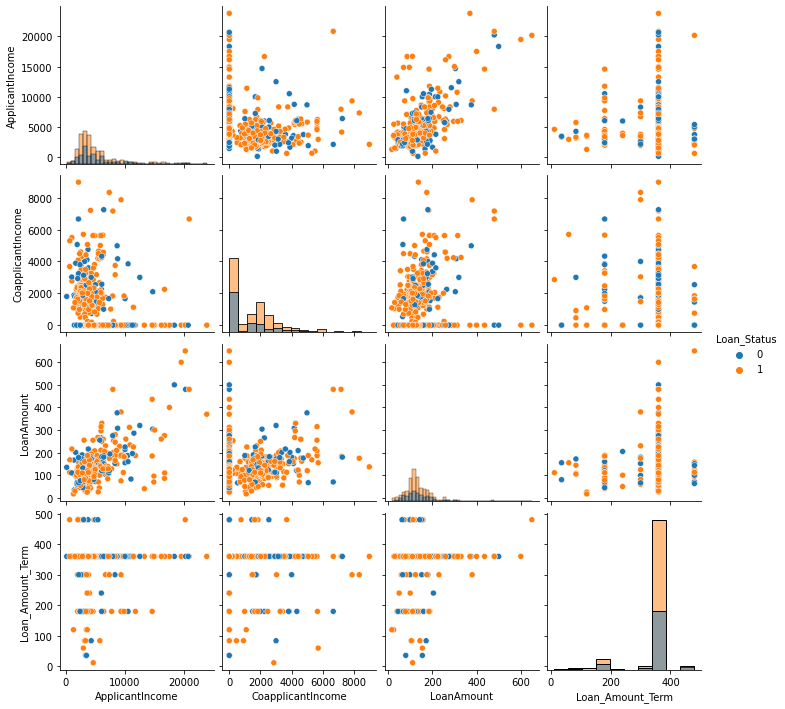

In [54]:
num_data = loan_data.loc[:,['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Loan_Status']]

sns.pairplot(num_data, kind="scatter", hue='Loan_Status', diag_kind="hist")
plt.show()

## Correlation Matrix

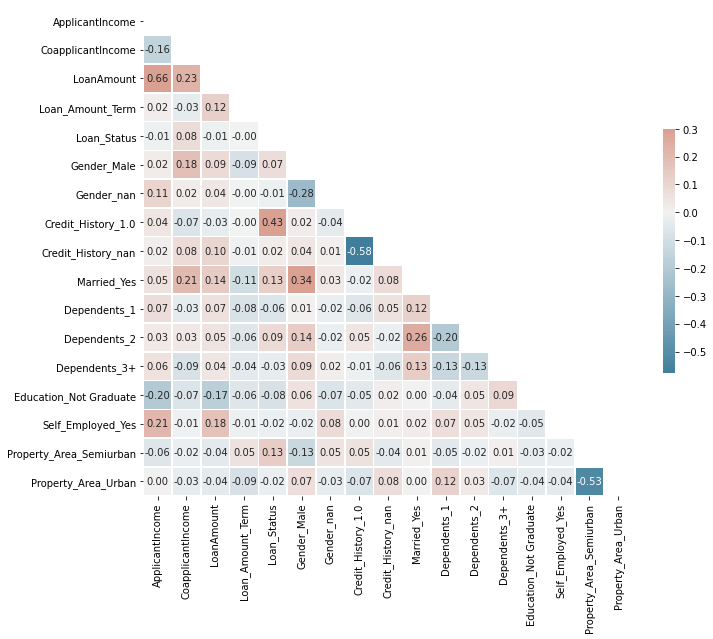

In [55]:
# Compute the correlation matrix
corr = loan_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [56]:
loan_data.LoanAmount.fillna(loan_data.LoanAmount.median(),inplace=True)
loan_data.Loan_Amount_Term.fillna(loan_data.Loan_Amount_Term.median(),inplace=True)

In [57]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481 entries, 0 to 490
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ApplicantIncome          481 non-null    int64  
 1   CoapplicantIncome        481 non-null    float64
 2   LoanAmount               481 non-null    float64
 3   Loan_Amount_Term         481 non-null    float64
 4   Loan_Status              481 non-null    int64  
 5   Gender_Male              481 non-null    uint8  
 6   Gender_nan               481 non-null    uint8  
 7   Credit_History_1.0       481 non-null    uint8  
 8   Credit_History_nan       481 non-null    uint8  
 9   Married_Yes              481 non-null    uint8  
 10  Dependents_1             481 non-null    uint8  
 11  Dependents_2             481 non-null    uint8  
 12  Dependents_3+            481 non-null    uint8  
 13  Education_Not Graduate   481 non-null    uint8  
 14  Self_Employed_Yes        4

## Separate the Input and Target Features of the data

In [58]:
y = loan_data['Loan_Status']
X = loan_data.drop(['Loan_Status'], axis = 1)

## Split the data into Train and Test Sets

In [60]:
# As requested in the assignment the train to test ratio should be 80:20 and the random_state should be 0.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Scaling the Data

In [61]:
transformed_data = X_train.loc[:,numerical].copy()


ct = ColumnTransformer([
    ('Standarization', StandardScaler(), numerical)
], remainder='passthrough')


transformed_data.loc[:,numerical] = ct.fit_transform(transformed_data)
X_train[numerical] = transformed_data

X_test[numerical] = ct.transform(X_test[numerical])
X_train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Male,Gender_nan,Credit_History_1.0,Credit_History_nan,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
268,0.420944,-0.839394,0.292123,0.273778,1,0,1,0,1,0,0,0,1,0,0,1
239,0.243190,-0.227240,-1.492875,0.273778,1,0,1,0,1,1,0,0,0,0,1,0
204,0.353303,0.441858,0.611824,0.273778,1,0,1,0,1,0,0,0,0,1,1,0
217,-0.113893,0.234841,0.292123,0.273778,1,0,0,0,1,0,0,1,0,0,0,1
282,1.575564,-0.839394,-0.347279,0.273778,1,0,1,0,1,0,1,0,0,0,0,1


## Random Forest Classifier

In [64]:
#baseline
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

## Baseline Results on the test set

Accuracy: 73.20%
Matthews Correlation Coefficient: 0.32
F1-Score: 82.19%
AUC Score: 0.63
Classification report: 
              precision    recall  f1-score   support

           0       0.65      0.35      0.46        31
           1       0.75      0.91      0.82        66

    accuracy                           0.73        97
   macro avg       0.70      0.63      0.64        97
weighted avg       0.72      0.73      0.71        97



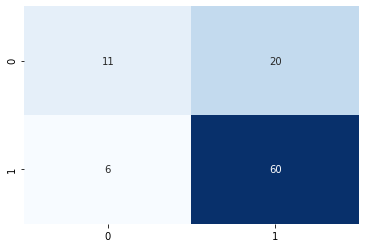

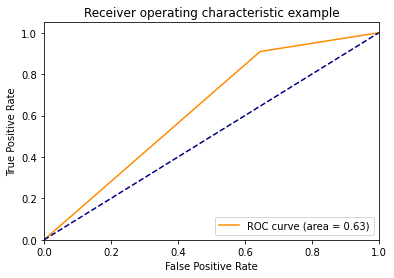

In [65]:
y_pred = rfc.predict(X_test)
# evaluate predictions
accuracy_test = accuracy_score(y_test, y_pred)
mcc_test = matthews_corrcoef(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)
auc_test = roc_auc_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy_test * 100.0))
print("Matthews Correlation Coefficient: %.2f" % (mcc_test))
print("F1-Score: %.2f%%" % (f1_test*100.0))
print("AUC Score: %.2f" % (auc_test))
print('Classification report: \n' + classification_report(y_test, y_pred))

cfm = confusion_matrix(y_test,y_pred)
sns.heatmap(cfm, cbar=False, annot=True, cmap='Blues', fmt='d')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Hyperparameter GridSearch

In [67]:
#Since it's a binary classification problem we will use AUC as the parameter for scoring

param_test1 = {
    'bootstrap':[True,False],
    'n_estimators':[10,25,50,75,100,150],
    'criterion':['gini', 'entropy'],
    'max_depth':[2,4,6,8],
    'min_samples_split':[2,3,4,5,6] ,
    'min_samples_leaf':[1,2,3,4,5],
    'max_features':['auto','sqrt','log2'],
    'oob_score':[True,False],
    'class_weight':['balanced','balanced_subsample',None],
    'random_state':[0]

}

gsearch1 = GridSearchCV(estimator = RandomForestClassifier(random_state=0), 
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5,
                       verbose=2)

gsearch1.fit(X_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 43200 candidates, totalling 216000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 1842 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 2732 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3786 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 5000 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 6378 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 7916 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 9618 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 11480 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 13506 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 15692 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 18042 tasks   

({'bootstrap': False,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 6,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 25,
  'oob_score': False,
  'random_state': 0},
 0.7921703197987784)

## Fine tuning

In [69]:
param_test2 = {
    'n_estimators':[15,20,25,30,35,40],
    'max_depth':[5,6,7],
    'min_samples_split':[4,5,6,7,8] ,
    'min_samples_leaf':[1,2,3,4],
}

gsearch2 = GridSearchCV(estimator = RandomForestClassifier(random_state=0,
                                                           bootstrap=False,
                                                           class_weight= None,
                                                           criterion='gini',
                                                           max_depth= 6,
                                                           max_features='auto',
                                                           min_samples_leaf=1,
                                                           min_samples_split= 6,
                                                           n_estimators=25,
                                                           oob_score= False,
                                     ), 
                        param_grid = param_test2, 
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5,
                       verbose=2)

gsearch2.fit(X_train, y_train)
gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 1785 out of 1800 | elapsed:   17.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   17.9s finished


({'max_depth': 5,
  'min_samples_leaf': 1,
  'min_samples_split': 7,
  'n_estimators': 25},
 0.7993346508563899)

In [72]:
#instatiating the model with the parameters found
model = RandomForestClassifier(random_state=0,
                                                           bootstrap=False,
                                                           class_weight= None,
                                                           criterion='gini',
                                                           max_depth= 5,
                                                           max_features='auto',
                                                           min_samples_leaf=1,
                                                           min_samples_split= 7,
                                                           n_estimators=25,
                                                           oob_score= False
                                     )
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_split=7,
                       n_estimators=25, random_state=0)

## Model Evaluation

Accuracy: 73.20%
Matthews Correlation Coefficient: 0.32
F1-Score: 82.43%
AUC Score: 0.62
Classification report: 
              precision    recall  f1-score   support

           0       0.67      0.32      0.43        31
           1       0.74      0.92      0.82        66

    accuracy                           0.73        97
   macro avg       0.71      0.62      0.63        97
weighted avg       0.72      0.73      0.70        97



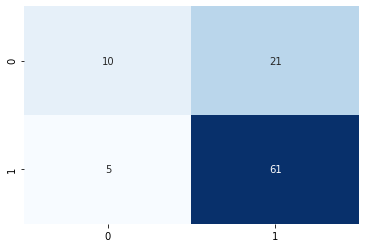

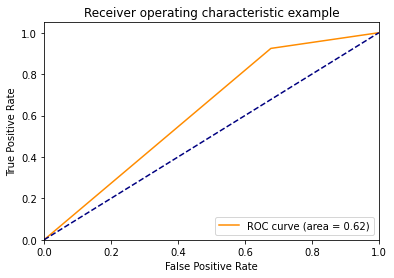

In [73]:
y_pred = model.predict(X_test)
# evaluate predictions
accuracy_test = accuracy_score(y_test, y_pred)
mcc_test = matthews_corrcoef(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)
auc_test = roc_auc_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy_test * 100.0))
print("Matthews Correlation Coefficient: %.2f" % (mcc_test))
print("F1-Score: %.2f%%" % (f1_test*100.0))
print("AUC Score: %.2f" % (auc_test))
print('Classification report: \n' + classification_report(y_test, y_pred))

cfm = confusion_matrix(y_test,y_pred)
sns.heatmap(cfm, cbar=False, annot=True, cmap='Blues', fmt='d')

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Explainability and features analysis

In [94]:
# creating an explainer for our model
explainer = shap.TreeExplainer(model, X_train, features_names=X_train.columns)

# finding out the shap values using the explainer
shap_values = explainer.shap_values(X_test)

# Expected/Base/Reference value = the value that would be predicted if we didn’t know any features of the current output”
print('Expected Value:', explainer.expected_value)

Expected Value: [0.30062955 0.69937045]


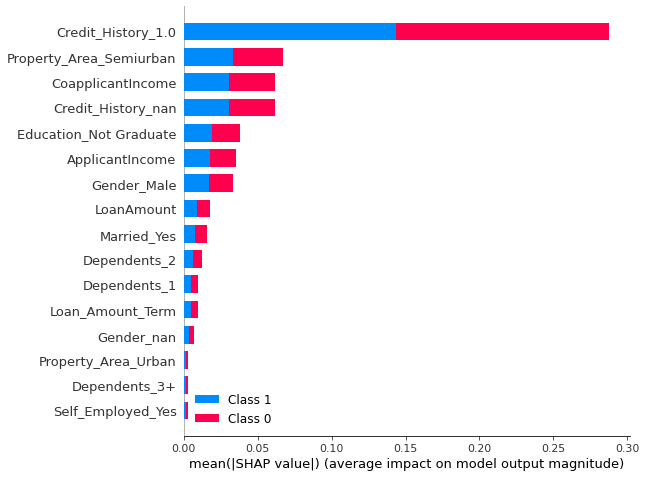

In [87]:
shap.summary_plot(shap_values, 
                  X_test, plot_type="bar")

## Predictions

In [92]:
test_data.drop(columns={'Loan_ID'},inplace=True)
test_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,0,Not Graduate,No,3748,1668.0,110.0,360.0,1.0,Semiurban
1,Male,Yes,3+,Graduate,No,4000,7750.0,290.0,360.0,1.0,Semiurban
2,Male,Yes,0,Graduate,No,2625,6250.0,187.0,360.0,1.0,Rural
3,Male,No,0,Not Graduate,No,3902,1666.0,109.0,360.0,1.0,Rural
4,Male,Yes,0,Not Graduate,No,6096,0.0,218.0,360.0,0.0,Rural


In [93]:
#Constructing a dataframe with the variable types and missing values per column
consistency = pd.DataFrame({'columns' : test_data.columns,
                    'type': test_data.dtypes,
                    'missing' : test_data.isna().sum(),
                    'size' : test_data.shape[0],
                    'unique': test_data.nunique()})
consistency['percentage'] = round(consistency['missing'] / consistency['size'],2)
consistency

,columns,type,missing,size,unique,percentage
Gender,Gender,object,3,123,2,0.02
Married,Married,object,2,123,2,0.02
Dependents,Dependents,object,6,123,4,0.05
Education,Education,object,0,123,2,0.00
Self_Employed,Self_Employed,object,3,123,2,0.02
ApplicantIncome,ApplicantIncome,int64,0,123,118,0.00
CoapplicantIncome,CoapplicantIncome,float64,0,123,63,0.00
LoanAmount,LoanAmount,float64,6,123,86,0.05
Loan_Amount_Term,Loan_Amount_Term,float64,1,123,6,0.01
Credit_History,Credit_History,float64,7,123,2,0.06


In [95]:

dummy_na = True #see why above
dummy_cols =['Gender', 'Credit_History']

#dummifying the columns above
test_data = create_dummy_df(test_data,dummy_cols,dummy_na)

test_data['Married'].fillna('No',inplace=True)
test_data['Dependents'].fillna('0',inplace=True)#this column is string type thus the '0'
test_data['Self_Employed'].fillna('No',inplace=True)

dummy_na = False #see why above
dummy_cols =['Married', 'Dependents','Education','Self_Employed','Property_Area']

#dummifying the columns above
test_data = create_dummy_df(test_data,dummy_cols,dummy_na)

test_data.LoanAmount.fillna(loan_data.LoanAmount.median(),inplace=True)
test_data.Loan_Amount_Term.fillna(loan_data.Loan_Amount_Term.median(),inplace=True)

test_data[numerical] = ct.transform(test_data[numerical])

test_data

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Male,Gender_nan,Credit_History_1.0,Credit_History_nan,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,-0.297940,0.150017,-0.373921,0.273778,1,0,1,0,0,0,0,0,1,0,1,0
1,-0.218658,3.757691,2.023837,0.273778,1,0,1,0,1,0,0,1,0,0,1,0
2,-0.651247,2.867932,0.651786,0.273778,1,0,1,0,1,0,0,0,0,0,0,0
3,-0.249490,0.148831,-0.387242,0.273778,1,0,1,0,0,0,0,0,1,0,0,0
4,0.440765,-0.839394,1.064734,0.273778,1,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,-0.003779,0.296531,0.625145,0.273778,1,0,1,0,0,0,0,0,0,0,1,0
119,-0.344188,0.103750,-0.160787,0.273778,1,0,1,0,1,0,1,0,1,0,0,0
120,-0.527920,-0.446121,-0.480488,0.273778,0,0,0,1,1,0,0,0,1,0,1,0
121,3.954018,-0.839394,1.157980,0.273778,0,0,1,0,0,0,0,0,1,1,1,0


In [96]:
#saving the predictions with Random Forest after grid search
prediction = model.predict(test_data)
index = range(0,len(prediction))
prediction = pd.DataFrame(data=prediction,index=index, columns=["prediction"])
prediction.to_csv('data/prediction__rfc_grid_search.csv',index=False)

In [99]:
#saving the predictions with Random Forest before grid search
prediction = rfc.predict(test_data)
index = range(0,len(prediction))
prediction = pd.DataFrame(data=prediction,index=index, columns=["prediction"])
prediction.to_csv('data/prediction_rfc.csv',index=False)

In [100]:
#saving the models

joblib.dump(rfc,'model/loan_model_rfc.dat')
joblib.dump(model,'model/loan_model_rfc_gs.dat')

['model/loan_model_rfc_gs.dat']

In [101]:
#saving the scaler


joblib.dump(ct,'model/scaler.pkl')

['model/scaler.pkl']

## Final Remarks

A couple of things could be tested still, such as:

1- Other models (this was only tested with random forest).

2- Consider the inclusion of outliers in the training process.

3- Categorize all the numerical variables.

4- Perform feature selection.


However the next step will be deploying the model.